# Loss functions & Gradient Descent
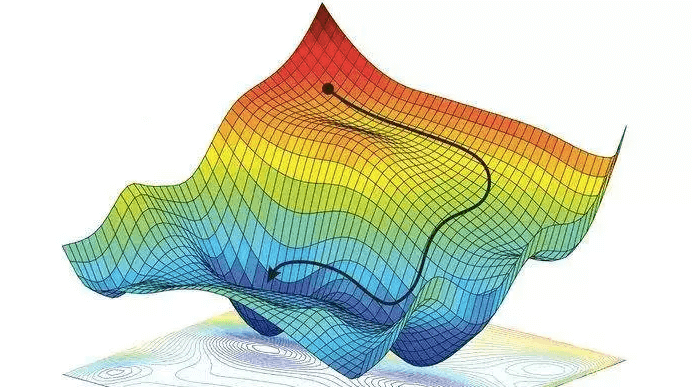

### Agenda

- Loss Functions for regression - Mean Square Error (MSE), Mean Absolute Error (MAE), and, Huber Loss
- Gradient descent - worked regression optimisation using MSE & MAE
- Logistic regression with Cross entropy loss (aka as log loss in binary classification)

Read about other loss functions (including focal loss):-<br>
https://medium.com/@roushanakrahmat/different-loss-functions-deep-learning-ae2cfaae4497

### Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.datasets import make_classification

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from pprint import pprint
from IPython.display import Image
from IPython.core.display import HTML 

## Loss functions for regression

### loss functions commonly used: -
1) mean square error (mse) - use when you don't have lots of outliers
2) mean absolute error (mae) - use when you have outliers
3) (mean) huber loss (in-between mse and mae) - but delta will need to be trained (n.b. delta is the cross over point between mse and mae)

#### mean square error / quadratic loss / L2 loss

In [2]:
def mse_loss(y_true, y_pred):
    """ returns the mean squared error for a set of y_true & y_pred """
    squared_difference = (y_pred - y_true)**2
    mse = np.mean(squared_difference)
    return mse

#### mean absolute error / L1 loss

In [3]:
def mae_loss(y_true, y_pred):
    """ returns the mean absolute error for a set of y_true & y_pred """
    absolute_difference = np.abs(y_pred - y_true)
    mae = np.mean(absolute_difference)
    return mae

#### huber loss / smooth mean absolute loss

In [4]:
def huber_loss_fn(y_pred, y_true, delta = 1):
    """ returns the huber loss for a set of y_true & y_pred """
    # compute the absolute difference
    absolute_difference = np.abs(y_pred - y_true)
    # Compute the Huber loss
    huber = np.where(absolute_difference <= delta, 
                      (1/2) * absolute_difference**2, 
                      delta * absolute_difference - (1/2) * delta**2)
    mean_huber_loss = np.mean(huber)   
    return mean_huber_loss

### compare loss functions

#### key point: hubor loss reduces reliance upon outliers (used in robust regression)

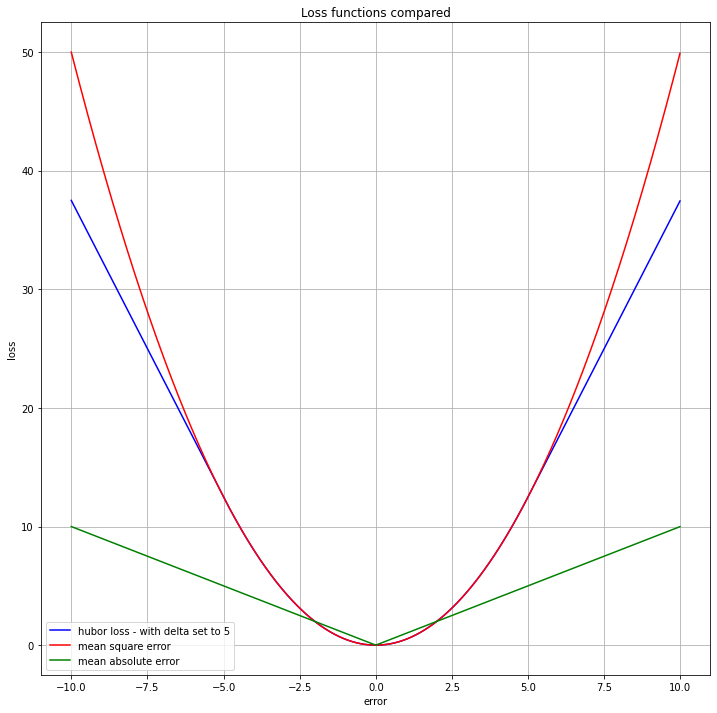

In [5]:
error_vals = np.arange(-10, 10, 0.01)

# huber values:-
delta = 2
huber_mse = 0.5*np.square(error_vals)
huber_mae = delta * (np.abs(error_vals) - 0.5 * delta)
huber_loss = np.where(np.abs(error_vals) <= delta, huber_mse, huber_mae)

# mean square error - focussed around the mean:-
mse = 0.5*np.square(error_vals)

# mean absolute error - focussed around the median:-
mae = np.abs(error_vals)

# huber values - focussed between the mean and median
delta = 5
huber_mse = 0.5*np.square(error_vals)
huber_mae = delta * (np.abs(error_vals) - 0.5 * delta)
huber_loss = np.where(np.abs(error_vals) <= delta, huber_mse, huber_mae)

# plot
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(error_vals, huber_loss, '-b', label=f"hubor loss - with delta set to {delta}")
ax.plot(error_vals, mse, '-r',label="mean square error")
ax.plot(error_vals, mae, '-g', label="mean absolute error")
plt.xlabel('error')
plt.ylabel('loss')
plt.title(f'Loss functions compared')
plt.grid(True, which="major")
leg = ax.legend();
plt.show()

## Worked Example of Batch Gradient descent using both mse and mae as the loss function

There are three main kinds of gradient descent listed below, but in this example we will focus on 'batch gradient descent'.
- Batch gradient descent: all training examples are used to update the model parameters
- Stochastic gradient descent: one observation is used to update the model parareters. More computation and can generate noisy gradients - but that might be good for avoiding local minima.
- Mini-batch gradient descent: splits the training dataset into small batch sizes and performs updates on each of those batches. It provides a balance between computation and avoiding noisy gradients.

### Create dataset

In [6]:
bias = 100.0
X, y_true, coef = make_regression(n_samples=100, n_features=1, bias=bias, noise=20,coef=True) 

In [7]:
X = np.squeeze(X)

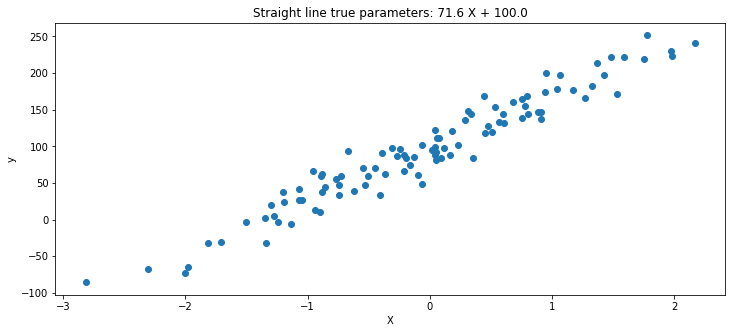

In [8]:
plt.figure(figsize=(12,5))
plt.scatter(X, y_true)
plt.title(label=f"""Straight line true parameters: {coef:.1f} X + {bias:.1f}""")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

### predict using: y=mX+c

In [9]:
def predict(X, m, c):
    """ Compute a prediction for each X value using the formula: y = mX + c """
    y = m*X + c
    return y

### plot ab-line

In [10]:
def ab_line(m, c, shape='--', color='red', label=""):
    """ plot ab line on scatterplot"""
    ax = plt.gca()
    _x = np.array(ax.get_xlim())
    _y = c+ m * _x
    plt.plot(_x, _y, shape, color=color, label=label)

In [11]:
def plot(X, y, m_mse, c_mse, m_mae, c_mae, m_huber, c_huber, mse_loss=np.nan, mae_loss=np.nan, huber=np.nan, epoch=""):
    """ Scatter plot with fitted line"""
    plt.figure(figsize=(12,5))
    plt.scatter(X, y)
    plt.title(f"""{epoch}
        mse: y = {m_mse:.1f} X + {c_mse:.1f} where mse_loss={mse_loss:.0f}
        mae: y = {m_mae:.1f} X + {c_mae:.1f} where mae_loss={mae_loss:.0f}
        huber: y = {m_huber:.1f} X + {c_huber:.1f} where huber={huber:.0f}
        """)
    ab_line(m=m_mse, c=c_mse, color='red',label='mse')
    ab_line(m=m_mae, c=c_mae, color='green',label='mae')
    ab_line(m=m_huber, c=c_huber, color='blue',label='huber')

### Update using the derivative (gradient) to update slope and intercept in order to reduce loss (i.e. optimise)

- Gradient is a measure of the steepness of a slope.
- The sum of all the first-order derivatives of all the variables of the loss function gives us gradient. 
- For example, if we consider linear regression, we have two parameters, slope, and the intercept, to minimize. So, we calculate derivatives w.r.t. both slope & the intercept.

Learning Rate (lr): This is the hyperparameter that determines the steps the gradient descent algorithm takes

Descent: To optimize parameters, we need to minimize errors. 

- The algorithm accomplishes this by an iterative process of calculating step size at every iteration. 
- And, this iterative calculation of step size to reach a local minimum (or in other words, descending to the point of minimum) is known as the descent.

In [12]:
def update_mse(m, c, X, y_true, y_pred, lr=0.2):
    """ compute new m and c using the gradients (derivatives) of mse loss function"""
    # see: https://towardsdatascience.com/linear-regression-using-gradient-descent-97a6c8700931
    
    n = float(len(X)) # Number of elements in X
    
    D_m = (-2/n) * sum(X * (y_true - y_pred))  # Derivative wrt m
    D_c = (-2/n) * sum(y_true - y_pred)  # Derivative wrt c

    m = m - lr * D_m  # Update m
    c = c - lr * D_c  # Update c   

    return m,c

In [13]:
def update_mae(m, c, X, y_true, y_pred, lr=0.2):
    """ compute new m and c using the gradients (derivatives) of mae loss function"""
    n = float(len(X)) # Number of elements in X
    
    D_m = sum(X * np.where(y_pred> y_true,1,-1)) # Derivative wrt m
    D_c = sum(np.where(y_pred> y_true,1,-1)) # Derivative wrt c

    m = m - lr * D_m  # Update m
    c = c - lr * D_c  # Update c   

    return m,c

In [14]:
def update_huber(m, c, X, y_true, y_pred, delta = 30, lr=0.2):
    """ compute new m and c using the gradients (derivatives) of huber loss """
    n = float(len(X)) # Number of elements in X
    
    # compute the absolute difference for the entire dataset
    absolute_difference = np.abs(y_pred - y_true)
        
    D_m = np.mean(np.where(absolute_difference <= delta,
                   (-2/n) * sum(X * (y_true - y_pred)), # derivative of mse loss
                   sum(X * np.where(y_pred> y_true,1,-1)))) # derivative of mae loss
    
    D_c = np.mean(np.where(absolute_difference <= delta,
                   (-2/n) * sum(y_true - y_pred), # derivative of mse loss
                   sum(np.where(y_pred> y_true,1,-1)))) # derivative of mae loss
                   
    m = m - lr * D_m  # Update m
    c = c - lr * D_c  # Update c   

    return m,c

## Demonstration of gradient descent with mse to optimise slope and intercept

In [15]:
def update(epochs=10):
    """ epochs is number of iterations of gradient descent"""
    mae_epochs = []
    mse_epochs = []
    huber_epochs = []
    
    # initial line for mse optimisation:-
    m_mse=0.0
    c_mse=0.0
    
    # initial line for mae optimisation:-
    m_mae=0.0
    c_mae=0.0
    
    # initial line for hubor optimisation:-
    m_huber=0.0
    c_huber=0.0
    
    # plot initial line before gradient descent
    plot(X,y_true, m_mse=m_mse, c_mse=c_mse, m_mae=m_mae, c_mae=c_mae, m_huber=m_huber, c_huber=c_huber, epoch=f"initial")
    plt.legend()
    plt.show()
    
    # iterate
    for e in range(epochs):
        
        # generate predictions using slope and intercept
        y_pred_mse = predict(X, m_mse, c_mse)
        y_pred_mae = predict(X, m_mae, c_mae)
        y_pred_huber = predict(X, m_huber, c_huber)
        
        ## Update slope and intercept using gradient descent
        mse = mse_loss(y_true, y_pred_mse)
        mse_epochs.append(mse)
        
        mae = mae_loss(y_true, y_pred_mse)
        mae_epochs.append(mae)
 
        huber = huber_loss_fn(y_true, y_pred_huber)
        huber_epochs.append(huber)   

        # Update slope and intercept using gradient descent
        m_mse, c_mse = update_mse(m_mse, c_mse, X, y_true, y_pred_mse, lr=0.2)
        m_mae, c_mae = update_mae(m_mae, c_mae, X, y_true, y_pred_mae, lr=0.2)
        m_huber, c_huber = update_huber(m_huber, c_huber, X, y_true, y_pred_huber, delta=40, lr=0.2) 
            
        # plot results
        plot(X,y_true, m_mse=m_mse, c_mse=c_mse, m_mae=m_mae, c_mae=c_mae, m_huber=m_huber, c_huber=c_huber, mse_loss=mse, mae_loss=mae, huber=huber, epoch=f"iteration {e}")
        plt.legend()
        plt.show()
    
        
    plt.figure(figsize=(12,5))
    plt.plot(mse_epochs,label='mse loss', color='red')
    plt.plot(mae_epochs, label='mae loss', color='green')
    plt.plot(huber_epochs, label='huber loss', color='blue')
    plt.title('losses by iteration')
    plt.xlabel('iteration')
    plt.legend()
    plt.show()
    return m_mse, c_mse, m_mae, c_mae, m_huber, c_huber

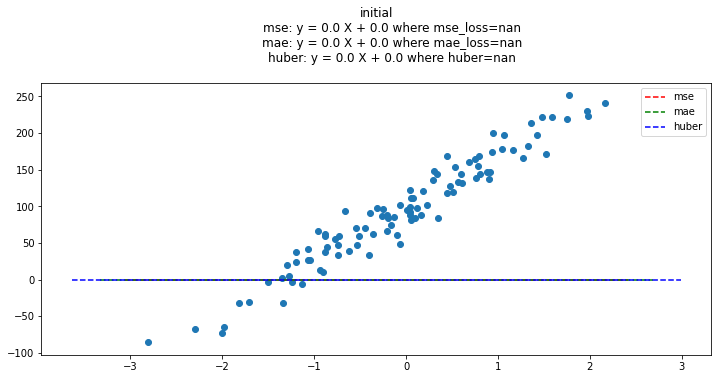

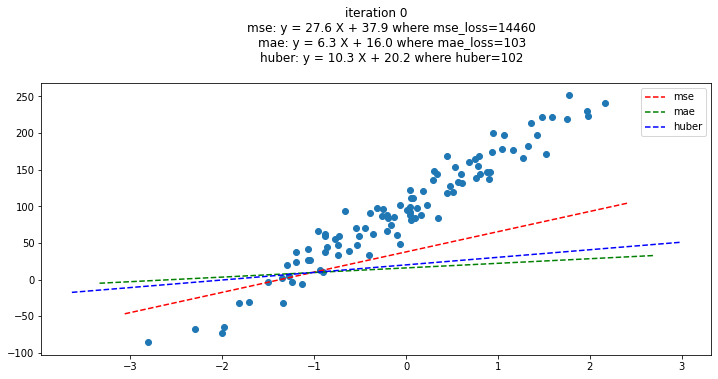

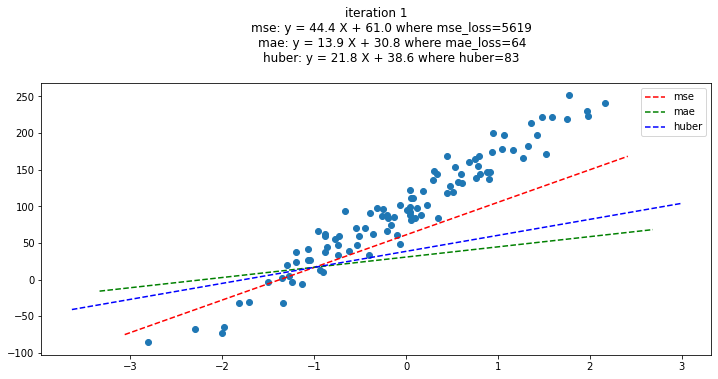

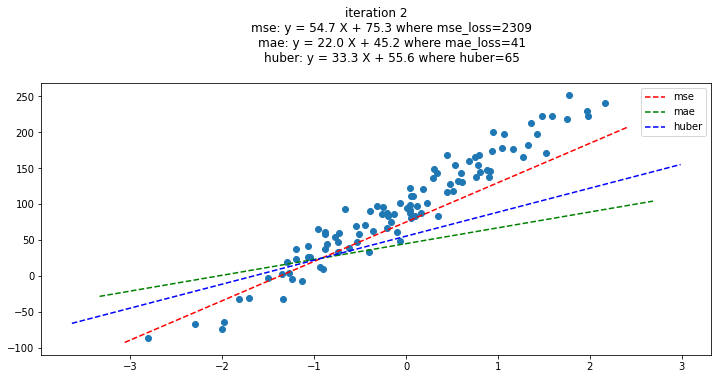

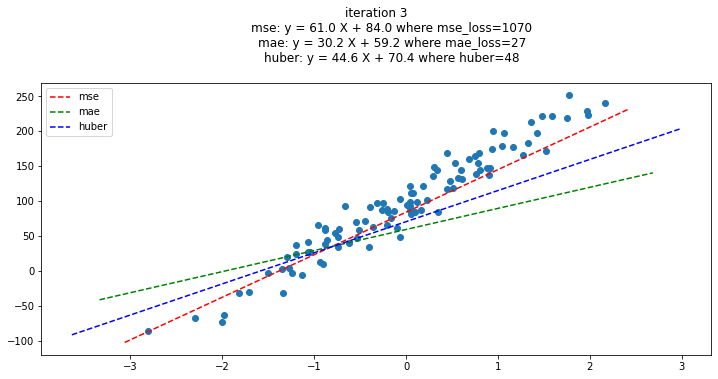

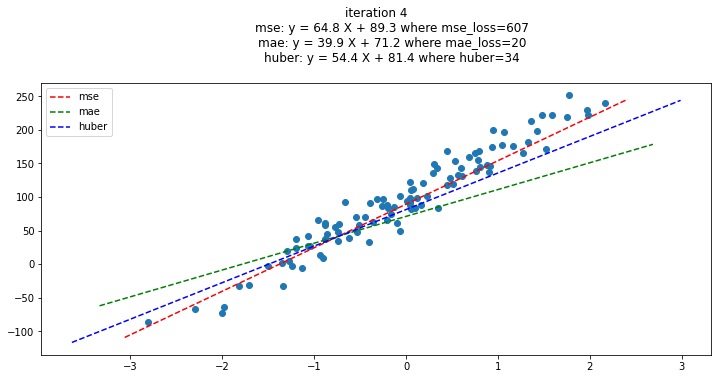

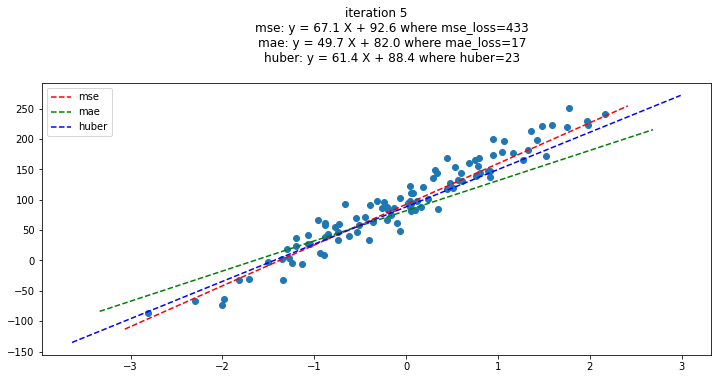

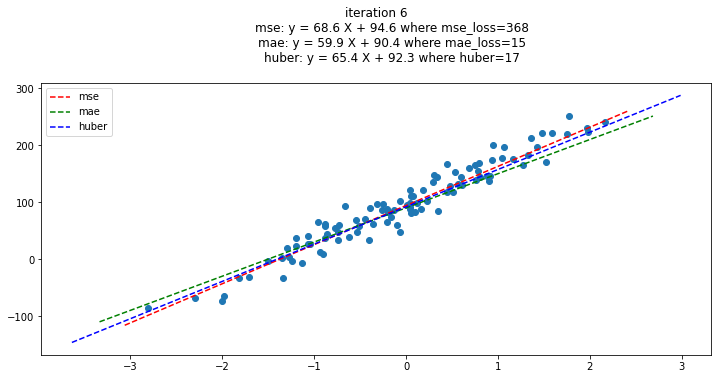

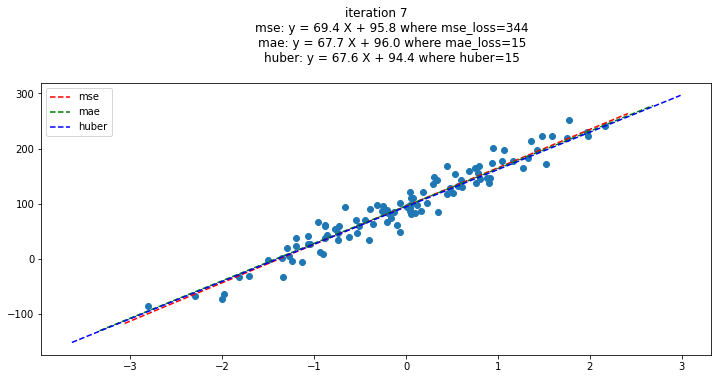

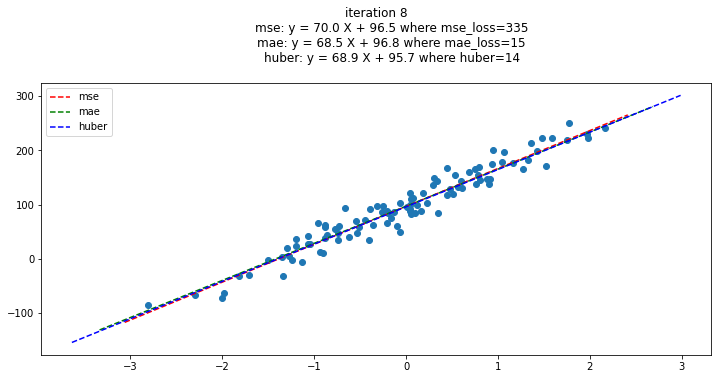

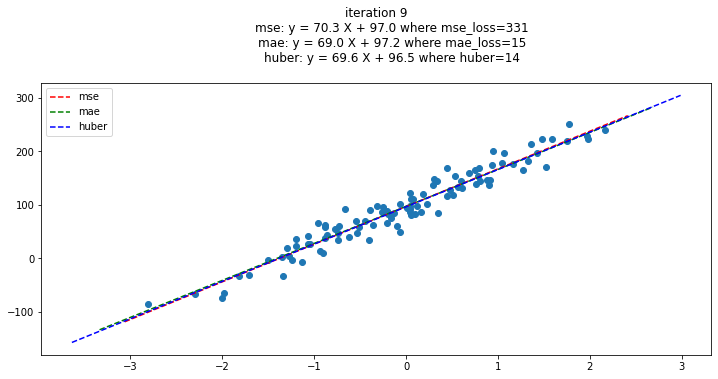

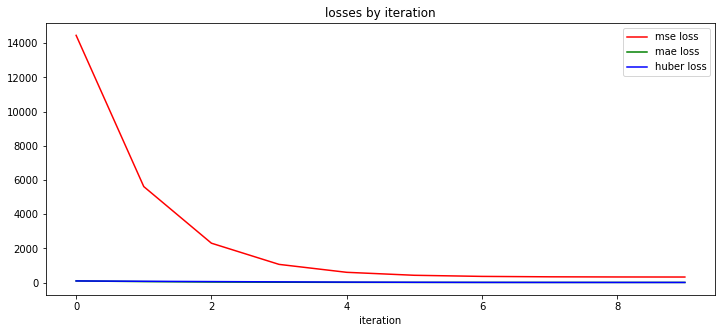

In [16]:
m_mse, c_mse, m_mae, c_mae, m_huber, c_huber = update()

# Classification

Classification Losses:
1) Log Loss (Cross-Entropy Loss)
2) SVM Loss (Hinge Loss)

### Logistic Regression
* Logistic Regression is a statisical model
* It uses the logistic function to model the dependent variable

### Data

In [17]:
X_logistic, y_logistic = make_classification(n_classes=2, n_clusters_per_class=1, random_state=12,
                                             n_features=2, n_informative=1, n_redundant=0)
y_logistic.shape

(100,)

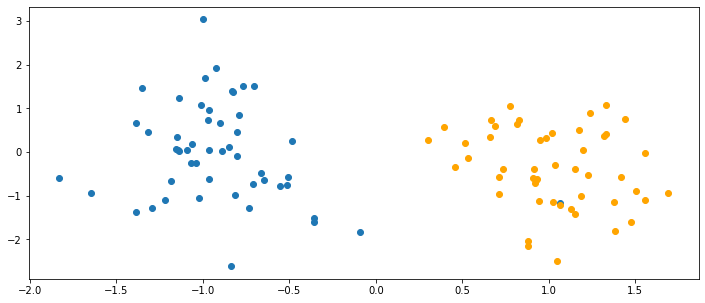

In [18]:
plt.figure(figsize=(12,5))
for idx, color in enumerate(['#1f77b4', 'orange']):
    plt.scatter(X_logistic[y_logistic==idx][:,0], X_logistic[y_logistic==idx][:,1], color=color)

## Formulation
* Sigmoid is a bounded, differentiable function
* It approaches 1 as X gets large and 0 as X gets small
* At 0 the value is 0.5
* With respect to neural network activations, we can saturate
    * Saturation occurs when X is very large or small
    * At those points, the derivative is very small
    * Learning can be slow with a saturated neuron (if using a Neural Network)

In [19]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

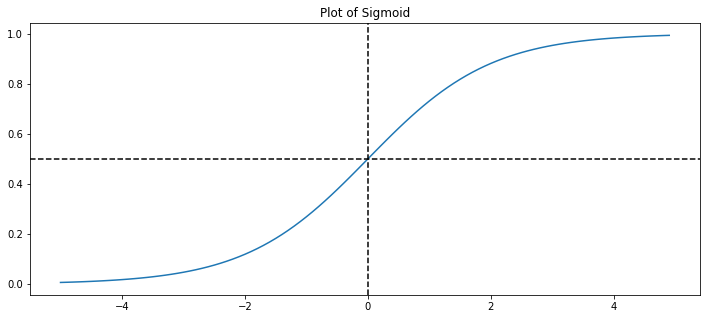

In [20]:
plot_x = np.arange(-5,5,0.1)
plot_y = sigmoid(plot_x)
plt.figure(figsize=(12,5))
plt.plot(plot_x, plot_y)
ax = plt.gca()
ax.axvline(x=0.0, ls='--', color='black')
ax.axhline(y=0.5, ls='--', color='black')
plt.title('Plot of Sigmoid');

## Weights
* Randomly initialize weights
* We'll have two parameters in this example

In [21]:
def initializeParameters(n_params=2):
    return np.random.uniform(-5, 5, n_params)

## Prediction
* We take the sigmoid of the dot / inner product of our data X and two parameters
* We round this to 0 or 1 to determine the class

In [22]:
def predictLogistic(X, parameters):
    return sigmoid(np.dot(X, parameters))

def predictClasses(X, parameters):
    return np.round(sigmoid(np.dot(X, parameters)))

## Loss
* We're using cross-entropy loss for our logistic function
    * loss = -log(sigmoid(X, W))     if y == 1
    * loss = -log(1 - sigmoid(X, W)) if y == 0
* Because log(0) is undefined, we're adding a small jitter
* Shapes:
    * y matrix is (100, 1)
    * predictions matrix is (100, 1)
    * We need to transpose the y matric to have our dot product correct 
    * (1, 100) @ (100, 1)
    * This returns 1 value, the overall loss


In [23]:
def logisticLoss(pred, y):
    eps = 1e-06
    cost = (-y).T @ np.log(pred + eps) - (1 - y).T @ np.log(1 - pred + eps)
    return cost

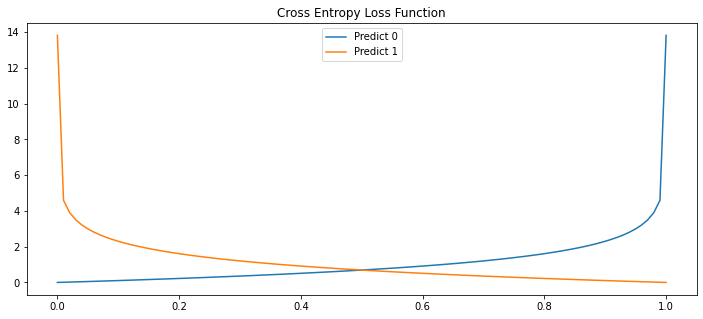

In [24]:
plt.figure(figsize=(12,5))
plot_x = np.linspace(0,1,100)
loss0 = -np.log(1 - plot_x + 1.e-06)
loss1 = -np.log(plot_x + 1.e-06)
plt.plot(plot_x, loss0, label='Predict 0')
plt.plot(plot_x, loss1, label='Predict 1')
plt.title('Cross Entropy Loss Function')
plt.legend();

## Derivatives
* https://medium.com/mathematics-behind-optimization-of-cost-function/derivative-of-log-loss-function-for-logistic-regression-9b832f025c2d

In [25]:
def derivativeLogistic(params, X, y):
    m = X.shape[0]
    dParams = (1 / m) * np.dot(X.T, (sigmoid(X @ params) - y))
    return dParams

## Update

In [26]:
def updateParameters(params, dParams, lr=0.01):
    params = params - lr * dParams
    return params

## Learning

In [27]:
epochs = 5000
losses = []
params = initializeParameters()
original_params = params.copy()

y_pred_original = predictClasses(X_logistic, params)

for e in range(epochs):
    preds = predictLogistic(X_logistic, params)
    loss  = logisticLoss(preds, y_logistic)
    losses.append(loss)
    dParams = derivativeLogistic(params, X_logistic, y_logistic)
    params  = updateParameters(params, dParams)

y_pred_complete = predictClasses(X_logistic, params)

## Beginning Errors
* Red is a point where we failed
* Green is a point we got corrent

              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90        47
         1.0       0.94      0.87      0.90        53

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100



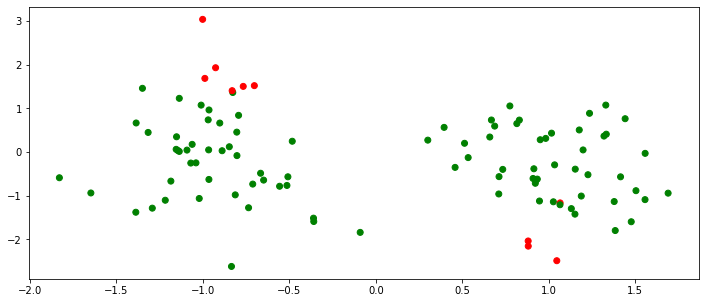

In [28]:
plt.figure(figsize=(12,5))
correct = y_pred_original == y_logistic
color = np.where(correct == True, 'green', 'red')
plt.scatter(X_logistic[:,0], X_logistic[:,1], color=color)
print(classification_report(y_pred_original, y_logistic))

## Ending Errors
* After training we have only one data point incorrectly classified

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        50
         1.0       1.00      0.98      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



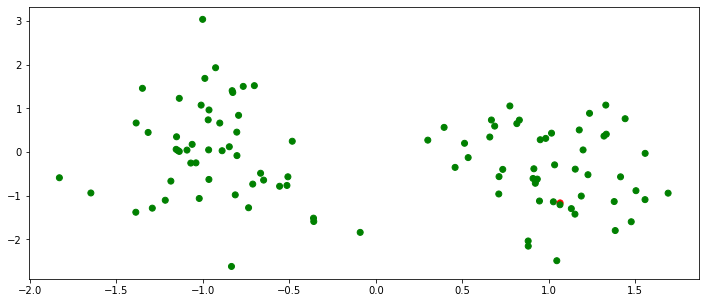

In [29]:
plt.figure(figsize=(12,5))
correct = y_pred_complete == y_logistic
color = np.where(correct == True, 'green', 'red')
plt.scatter(X_logistic[:,0], X_logistic[:,1], color=color)
print(classification_report(y_pred_complete, y_logistic))

## Losses by Epoch

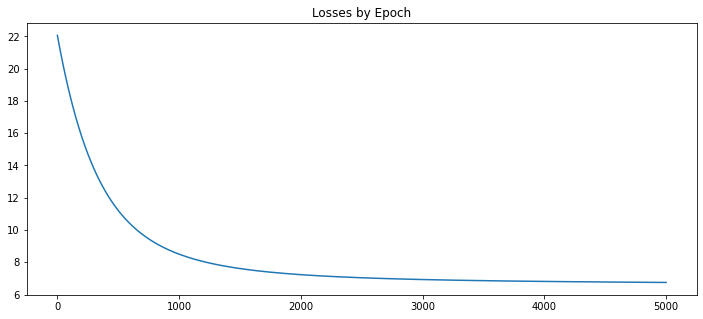

In [30]:
plt.figure(figsize=(12,5))
plt.plot(losses)
plt.title('Losses by Epoch');